In [1]:
import pandas as pd
import numpy as np  
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [2]:
# For reproducibility of results
np.random.seed(0)

# Load the dataset if selected_features.csv does exist
if os.path.exists("selected_features.csv"):
    selected_features = pd.read_csv("selected_features.csv")
    print(selected_features.head())
else:
    print("The dataset is not present in the current directory.")

       2      7      8     11     14     15     17     18     21     22  ...  \
0 -0.684 -0.113  0.401 -0.251 -0.178  0.321  0.016 -0.003 -0.275 -0.162  ...   
1 -0.529 -0.066 -0.168 -0.205  0.020  0.031 -0.165 -0.026 -0.130  0.176  ...   
2 -0.240  0.031 -0.077 -0.036 -0.005  0.170  0.212  0.138 -0.300  0.689  ...   
3 -0.062 -0.143  0.068 -0.295 -0.188 -0.317 -0.113  0.018 -0.272 -0.531  ...   
4 -0.203 -0.168  0.008  0.166 -0.048 -0.291 -0.091  0.062  0.026 -0.036  ...   

      54     56     57     58     59     60     64     66     68  label  
0 -0.263 -0.075 -0.327 -0.198 -0.257 -0.205 -0.223 -0.136 -0.132      0  
1 -0.064  0.004 -0.305 -0.018 -0.230 -0.150 -0.151 -0.031 -0.097      0  
2 -0.149  0.102 -0.189 -0.112 -0.121  0.121 -0.172  0.033 -0.321      0  
3 -0.245 -0.153 -0.405 -0.102 -0.120 -0.141 -0.292 -0.078 -0.151      0  
4  0.043 -0.099 -0.188  0.042 -0.124 -0.097 -0.165 -0.112 -0.138      1  

[5 rows x 31 columns]


In [3]:
labels = selected_features.iloc[:, -1]
features = selected_features.iloc[:, :-1]

features, labels

(            2         7         8        11        14        15        17  \
 0   -0.684000 -0.113000  0.401000 -0.251000 -0.178000  0.321000  0.016000   
 1   -0.529000 -0.066000 -0.168000 -0.205000  0.020000  0.031000 -0.165000   
 2   -0.240000  0.031000 -0.077000 -0.036000 -0.005000  0.170000  0.212000   
 3   -0.062000 -0.143000  0.068000 -0.295000 -0.188000 -0.317000 -0.113000   
 4   -0.203000 -0.168000  0.008000  0.166000 -0.048000 -0.291000 -0.091000   
 ..        ...       ...       ...       ...       ...       ...       ...   
 391 -0.240811  0.160049 -0.172790  0.431347  0.430861 -0.305451 -0.119770   
 392 -0.179418 -0.000023 -0.260852  0.237564 -0.080075 -0.354038 -0.004051   
 393 -0.553610 -0.005744 -0.068708 -0.253044  0.017528 -0.070628 -0.172178   
 394  0.203276 -0.036268 -0.253699  0.382949  0.295444  0.049701 -0.245894   
 395 -0.221108  0.450663 -0.293762  0.042793  0.153844 -0.268618 -0.083691   
 
            18        21        22  ...        53        54   

## Min-Max

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset_normalized = scaler.fit_transform(features)
dataset_normalized

array([[0.18304732, 0.49900892, 0.89076305, ..., 0.33932274, 0.34881517,
        0.52682455],
       [0.26365055, 0.52229931, 0.43373494, ..., 0.38908086, 0.44834123,
        0.54374094],
       [0.41393656, 0.5703667 , 0.50682731, ..., 0.37456807, 0.50900474,
        0.43547608],
       ...,
       [0.25085283, 0.55215857, 0.51348755, ..., 0.31353283, 0.41787867,
        0.28746834],
       [0.6444493 , 0.53703271, 0.3649004 , ..., 0.57430339, 0.55802938,
        0.67151474],
       [0.42376079, 0.77832656, 0.33272129, ..., 0.38708569, 0.42213365,
        0.63412131]])

# DecisionTreeClassifier

In [5]:
# Import necessary libraries for stratified k-fold cross-validation and decision tree classifiers
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef

In [6]:
from math import log

# Define una función para calcular la entropía
def entropy(y):
    class_counts = np.bincount(y)
    probabilities = class_counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

# Define una función para calcular la ganancia de información
def information_gain(y, splits):
    parent_entropy = entropy(y)
    total_samples = len(y)
    child_entropy = sum((len(child) / total_samples) * entropy(child) for child in splits)
    return parent_entropy - child_entropy

In [7]:
# Initialize StratifiedKFold with 10 folds and a random seed for reproducibility
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# Initialize decision tree classifiers with different criterion
id3 = DecisionTreeClassifier(criterion='entropy')
c45 = DecisionTreeClassifier(criterion='entropy')
cart = DecisionTreeClassifier(criterion='gini', splitter='random')

# Store classifiers in a list for easy iteration
classifiers = [('ID3', id3), ('C4.5', c45), ('CART', cart)]

In [8]:
# Initialize lists to store metrics for each classifier
conf_matrices = []
acc_scores = []
pre_scores = []
rec_scores = []
auc_scores = []
f1_scores = []
mcc_scores = []
sensitivity_scores = [] 
specificity_scores = [] 

# Loop through each classifier
for name, clf in classifiers:
    # Initialize lists to store metrics for each fold
    conf_matrix_fold = []
    acc_scores_fold = []
    pre_scores_fold = []
    rec_scores_fold = []
    auc_scores_fold = []
    f1_scores_fold = []
    mcc_scores_fold = []
    sensitivity_scores_fold = [] 
    specificity_scores_fold = [] 
    
    # Loop through each fold
    for train_index, test_index in skf.split(dataset_normalized, labels):
        # Split the dataset into training and testing sets
        X_train, X_test = dataset_normalized[train_index], dataset_normalized[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        
        # Fit the classifier and make predictions
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        
        # Calculate metrics and append to lists
        conf_matrix_fold.append(confusion_matrix(y_test, y_pred))
        acc_scores_fold.append(accuracy_score(y_test, y_pred))
        pre_scores_fold.append(precision_score(y_test, y_pred))
        rec_scores_fold.append(recall_score(y_test, y_pred))
        auc_scores_fold.append(roc_auc_score(y_test, y_pred_proba))
        f1_scores_fold.append(f1_score(y_test, y_pred))
        mcc_scores_fold.append(matthews_corrcoef(y_test, y_pred))
           # Calculate sensitivity and specificity
        true_positives = conf_matrix_fold[-1][1, 1]
        true_negatives = conf_matrix_fold[-1][0, 0]
        false_positives = conf_matrix_fold[-1][0, 1]
        false_negatives = conf_matrix_fold[-1][1, 0]
        
        sensitivity = true_positives / (true_positives + false_negatives)
        specificity = true_negatives / (true_negatives + false_positives)
        
        sensitivity_scores_fold.append(sensitivity)
        specificity_scores_fold.append(specificity)
    
    # Append mean and standard deviation of metrics for each classifier
    conf_matrices.append(np.mean(conf_matrix_fold, axis=0))
    acc_scores.append((np.mean(acc_scores_fold), np.std(acc_scores_fold)))
    pre_scores.append((np.mean(pre_scores_fold), np.std(pre_scores_fold)))
    rec_scores.append((np.mean(rec_scores_fold), np.std(rec_scores_fold)))
    auc_scores.append((np.mean(auc_scores_fold), np.std(auc_scores_fold)))
    f1_scores.append((np.mean(f1_scores_fold), np.std(f1_scores_fold)))
    mcc_scores.append((np.mean(mcc_scores_fold), np.std(mcc_scores_fold)))
    sensitivity_scores.append((np.mean(sensitivity_scores_fold), np.std(sensitivity_scores_fold)))  
    specificity_scores.append((np.mean(specificity_scores_fold), np.std(specificity_scores_fold))) 

# Display metrics for each classifier
for i, (name, _) in enumerate(classifiers):
    print(f"Classifier: {name}")
    print(f"Confusion Matrix:\n{conf_matrices[i]}")
    print(f"Accuracy: Mean = {acc_scores[i][0]}, Std = {acc_scores[i][1]}")
    print(f"Precision: Mean = {pre_scores[i][0]}, Std = {pre_scores[i][1]}")
    print(f"Recall: Mean = {rec_scores[i][0]}, Std = {rec_scores[i][1]}")
    print(f"AUC: Mean = {auc_scores[i][0]}, Std = {auc_scores[i][1]}")
    print(f"F1 Score: Mean = {f1_scores[i][0]}, Std = {f1_scores[i][1]}")
    print(f"MCC: Mean = {mcc_scores[i][0]}, Std = {mcc_scores[i][1]}")
    print(f"Sensitivity: Mean = {sensitivity_scores[i][0]}, Std = {sensitivity_scores[i][1]}")  
    print(f"Specificity: Mean = {specificity_scores[i][0]}, Std = {specificity_scores[i][1]}")  
    print("\n")

Classifier: ID3
Confusion Matrix:
[[10.7  8.7]
 [ 5.8 14.4]]
Accuracy: Mean = 0.6339102564102564, Std = 0.05683584358809859
Precision: Mean = 0.6248838520577651, Std = 0.050668974540963634
Recall: Mean = 0.7133333333333334, Std = 0.10657627973128235
AUC: Mean = 0.6321929824561404, Std = 0.057182799158881505
F1 Score: Mean = 0.6626572704874818, Std = 0.06241726200085583
MCC: Mean = 0.2728077229815868, Std = 0.11779502785154287
Sensitivity: Mean = 0.7133333333333334, Std = 0.10657627973128235
Specificity: Mean = 0.5510526315789473, Std = 0.0940707578327313


Classifier: C4.5
Confusion Matrix:
[[10.9  8.5]
 [ 5.9 14.3]]
Accuracy: Mean = 0.6364102564102564, Std = 0.07975286449485548
Precision: Mean = 0.6253547524483373, Std = 0.0685247930751615
Recall: Mean = 0.7080952380952381, Std = 0.1323184161986007
AUC: Mean = 0.6347055137844613, Std = 0.07947007633312686
F1 Score: Mean = 0.6610311047117627, Std = 0.0901166014650391
MCC: Mean = 0.27768321092338044, Std = 0.16299209721309674
Sensitivit

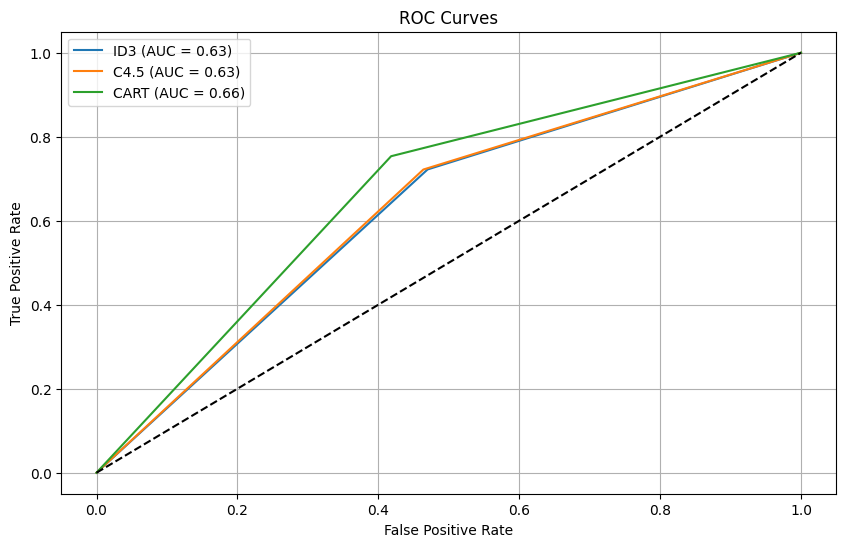

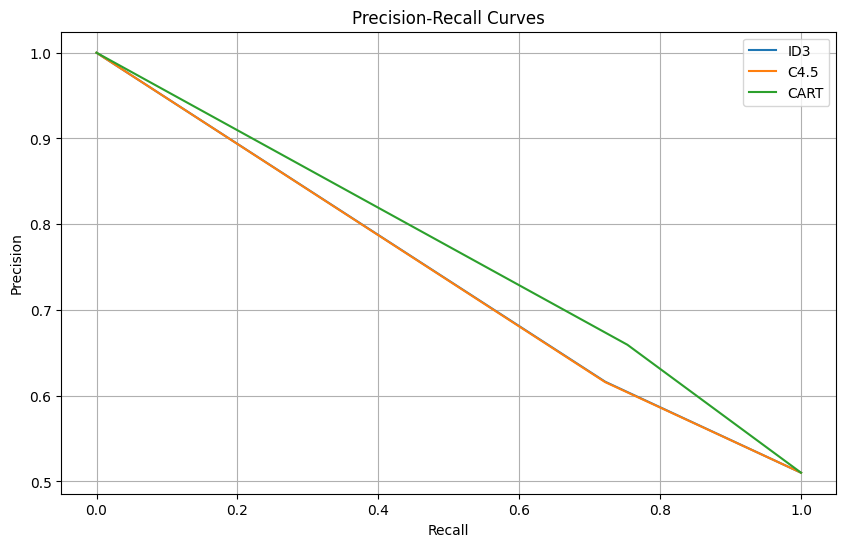

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# Initialize lists to store metrics for plotting
tpr_list = []
fpr_list = []
precision_list = []
recall_list = []

# Loop through each classifier
for name, clf in classifiers:
    # Initialize lists to store metrics for each fold
    tpr_fold = []
    fpr_fold = []
    precision_fold = []
    recall_fold = []
    
    # Loop through each fold
    for train_index, test_index in skf.split(dataset_normalized, labels):
        # Split the dataset into training and testing sets
        X_train, X_test = dataset_normalized[train_index], dataset_normalized[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        
        # Fit the classifier and make predictions
        clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        
        # Calculate metrics and append to lists
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        tpr_fold.append(tpr)
        fpr_fold.append(fpr)
        precision_fold.append(precision)
        recall_fold.append(recall)
    
    # Calculate mean and standard deviation of metrics for plotting
    tpr_mean = np.mean(tpr_fold, axis=0)
    fpr_mean = np.mean(fpr_fold, axis=0)
    precision_mean = np.mean(precision_fold, axis=0)
    recall_mean = np.mean(recall_fold, axis=0)
    
    # Append metrics for each classifier
    tpr_list.append(tpr_mean)
    fpr_list.append(fpr_mean)
    precision_list.append(precision_mean)
    recall_list.append(recall_mean)

# Plot AUC for each classifier
plt.figure(figsize=(10, 6))
for i, (name, _) in enumerate(classifiers):
    plt.plot(fpr_list[i], tpr_list[i], label=f'{name} (AUC = {auc_scores[i][0]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# Plot precision vs recall for each classifier
plt.figure(figsize=(10, 6))
for i, (name, _) in enumerate(classifiers):
    plt.plot(recall_list[i], precision_list[i], label=f'{name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()